# Deep dream
More like weird dream.  
<img src="images/deepdream.jpg" width="500" />  
  
  
After training a CNN each of its layers act as a feature classifiers, deeper layers classify more complex features like eyes and even faces, shallower layers classify less complex features like edges or texture.  
Having that in mind, if you manipulate the data in a given image to maximize the activations of the layer that classifies, let's say, eyes, Then this image is going to seem like it has so many eyes in it. This is basically the concept of deep dream.  
# Plan of attack
* Get a pretrained model (we'll use InceptionV3)
* Feed an image through this model and get some layers' outputs
* Maximize those ouputs WRT the image data

Let's import important modules first

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

import IPython.display as display
from PIL import Image
from tensorflow.keras.preprocessing import image

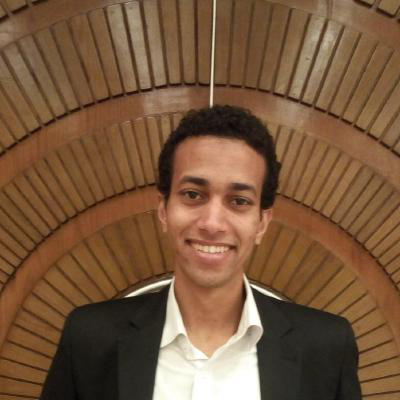

In [2]:
# now let's define some helper functions
# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(Image.fromarray(np.array(img)))
    
img = Image.open("images/avatar.jpg")
show(img)

## Load pretrained model
We'll use the InceptionV3 model in the applications module

In [3]:
inc = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")

In [4]:
inc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Choose layers to maximize
We could use one layer but let's get the general case and choose more than one

In [5]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [inc.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=inc.input, outputs=layers)

## Maximize activations WRT image
First you need to have a well defined function to maximize.  
Let's do that now

In [6]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [7]:
# remember we need to maximize, and that is not the default in tensorflow
# we dont't want to subtract the gradient from the image, we want to add it
# so let's define everything ourselvs

class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
        
        
    # this decorator is used for performance purposes
    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            
            gradients = tape.gradient(loss, img)
            
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
        
        return loss, img



In [8]:
# now let's create an instance of that class
deepdream = DeepDream(dream_model)

In [9]:
# let's create a function to make our lives easier
def run_deep_dream(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)
    
    return result

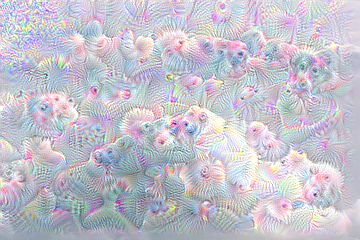

In [12]:
orig = mpimg.imread("images/white.jpg")
dream_img = run_deep_dream(img=orig, 
                                  steps=100, step_size=0.01)